### Multiple Sequence Alignment & Profiles
#### Author(s): [[Write Your Name(s) Here]].
AutoTemplate by AhmetSacan. <br><br>
You may use any function available in Matlab for this assignment. If you are using python, you may use Biopython for sequence processing and any third party package for drawing sequence logos.

In [4]:
import numpy as np
import math 
import matplotlib.pyplot as plt
import bmes
from Bio import SeqIO, Align, pairwise2
import pandas as pd
import shlex
import subprocess
import time
#import logomaker as lm
# !pip install logomaker

### Obtaining homologous sequences
This section can be done manually. You do not need to write any code for this section.<br><br>
Run PSI-BLAST (http://blast.ncbi.nlm.nih.gov/Blast.cgi) against non-redundant GenBank database. Use E-value of 0.1 and a maximum of 1000 target sequences.

In [449]:
# '''
# # {
# >malnhw
# MVEMLPTVVALVLAVSVVAKDNTTCDGPCGLRFRQNPQAGIRIVGGQTSSPGAWPWMVSL
# QIFTSHNSRRYHACGGSLLNSHWVLTAAHCFDNKKKVYDWRLVFGAHEIEYGRNKPVKEP
# QQERYVQKIVIHEKYNAVTEGNDIALLKVTPPVTCGDFVGPGCLPHFKSGPPRIPHTCYV
# TGWGYIKDNAPRPSPVLMEARVDLIDLDLCNSTQWYNGRVTSTNVCAGYPEGKIDTCQGD
# SGGPLMCRDSVDSPFVIVGITSWGVGCARAKRPGVYTATWDYLDWIASKIGPTALHLIQP
# ATPHPPTTQQPVISFHPPSIHPPWYFQHLSPRPPHLRPPRPLLHQPSSVHTSSAPVIPLL
# SLLTPVQPVSFTLAAYHTRHHTTLSFARRLQHLIEALKMRTYPIKYPSRYSGPVNYQHRF
# STFEPLSNKPSEPLLHS
# }
#  '''

Download (manually, outside your code) the PSI-BLAST hits (download the aligned sequences, not the complete sequences) into a file named blastresult.fasta in this folder.

### Removing redundant BLAST results
Blast will contain many similar results. You will remove this redundancy in the BLAST results to ensure some sequences/organisms donot dominate the multiple alignment analaysis and to also minimize computation time in such analysis. Write a function fasta_removeredundants(file,identthreshold) that takes as input a fasta filename and produces a new file with '.nonredundant.fasta' appended to the input filename. e.g, if the input is 'abc.fasta', your function should produce the file 'abc.fasta.nonredundant.fasta'. Your function should read in the entries contained in the input fasta file and remove any entry that is more than "identthreshold" similar to any of the entries that appear before it. e.g., if 2nd and 5th sequences are more similar to each other than "identthreshold", you should remove the 5th sequence. Once you remove the 5th sequence, the 5th should also not be considered for any further similarity comparisons with the sequences that come after it. If identthreshold is not given, use 0.95 by default. When calculating the identity between two sequences, use Global Alignment with free end gaps. Assume that the input fasta file contains protein sequences. Your function should return the fraction of the sequences that were removed.

In [528]:
fasta_seq = SeqIO.parse('blastresult.fasta','fasta')
submat = Align.substitution_matrices.load("BLOSUM62")
unfil_seq = list(fasta_seq)[:10] #use this to run code so you don't use all 1000 sequences 

In [529]:
len(unfil_seq) 

10

In [ ]:
t0 = time.time()
index_avoid = [] #indicies for the for loop to avoid for better speed this will be used to filter final list 

for i in range(len(unfil_seq)):
    if i in index_avoid:
        continue
    for j in range(i+1,len(unfil_seq)):
        if unfil_seq[i].seq != unfil_seq[j].seq:
            align = pairwise2.align.globaldx(unfil_seq[i].seq, unfil_seq[j].seq,submat, penalize_end_gaps =False, one_alignment_only=True)
            a = align[0].seqA
            b = align[0].seqB
            denom = (align[0].end -align[0].start)
            count = 0 
        for k in range(len(a)):
            if a[k]==b[k]:
                count +=1
                p_id = count/denom
        if p_id > .90: #sample threshold
            index_avoid.append(j)

fil_seq = [i for j, i in enumerate(unfil_seq) if j not in index_avoid] #filtered sequences to be written into non redudnant fasta file
percent_loss = (len(unfil_seq) - len(fil_seq))/len(unfil_seq) #calculation for amount of sequences lossed
print(percent_loss)
t1 = time.time()
total = (t1-t0)
print(f'Secs: {total}')

In [ ]:
file_out = 'blastresult.fasta.nonredundant.fasta ' #sample file to continue code below
write_file = SeqIO.write(fil_seq, file_out, 'fasta') 

In [ ]:
def fasta_removeredundants(file, identthreshold=.95): #have completed the function yet because its so slow 

In [ ]:
# Do not change this line of code.
print(f'{fasta_removeredundants('blastresult.fasta',0.9)*100} of the sequences were removed.\n')

### Running Multiple Sequence Alignment Algorithm
Run ClustalOmega to multiple-align the sequences contained in the blastresult.fasta.nonredundant.fasta file (in this folder). Store the result in malnresult.fasta (in this folder).<br><br>
Manually running the ClustalOmega outside your code is not acceptable here. You must run ClustalOmega in your code. You can rely on a system() call to run external commands. If you are using Python, you can use subprocess.check_output(), subprocess.run() or other functions for that purpose.

In [ ]:
# The following is the recommended location for the clustalo.exe. If you
# install ClustalOmega elsewhere, make sure to modify the following line
# accordingly. Do NOT install Clustalomega in your course dropbox folder.

CLUSTALEXE='C:/bmes/clustal-omega-1.2.2-win64/clustalo.exe' #may have to change the location for it work on your computer
resultname = 'malnresult.fasta'
cmd = shlex.split(f'{CLUSTALEXE} -i blastresult.fasta.nonredundant.fasta -o {resultname}')
process = subprocess.run(cmd, 
                         stdout=subprocess.PIPE, 
                         universal_newlines=True)
process

### Load the Seqences
Read in the sequences from the multiple alignment fasta file. If you are working in Matlab, it will be convenient to keep the entire alignment in a character matrix.<br><br>
Remove any alignment columns that have a gap in the first sequence. After this "cleanup", the first sequence of the multiple alignment will not have any gaps, but there may be gaps in the remaining sequences.

In [8]:
result_fasta = SeqIO.parse('malnresult.fasta','fasta') #read in clustal file
result_fasta = [x.seq for x in result_fasta] #gather all of the seqs from file into a list
raw_seq = np.asarray(result_fasta) #convert the multiple alignments  into a numpy array to better clean up alignments
cleanup_seq = np.empty((484,0),dtype=str) #create an empty array that will contain cleaned alignments

for i in range(len(raw_seq[0])): #this for loop goes through the first row which contains the reference sequences and deletes any columun with a gap character
    del_col = raw_seq[0][i]      #then any column in the first row without a gap is append to empty array for the final processed alignments
    insert_col = [raw_seq[:,i]]
    if del_col !="-":
        cleanup_seq = np.append(cleanup_seq,np.array(insert_col).T,axis=1)


### Calculate PSSM
Calculate the PSSM matrix from the multiple alignment produced by clustalomega. Your matrix should have 20 rows and as many columns as there are in the multiple sequence alignment. Use a pseudocount of 1 for each amino acid type (i.e., pretend there are 20 additional fake sequences in the multiple alignment, each sequence composed of only one of the amino acid types).<br><br>
In your PSSM, do not have an entry for the gap character. In each column, divide each amino acid count with the number of non-gap characters in that column. So, if you have a column with 50% A's and 50% gaps, the frequency of A should be 100% (slightly lower than 100% after pseudocount correction).

In [9]:
aa_letters = 'ACDEFGHIKLMNPQRSTVWY' #single letter protein abbrv
aa_list = [char for char in aa_letters] #protein abbrv into a list for easier computation
aa_table = pd.DataFrame(cleanup_seq)

In [10]:
aa_col_weight = {} #this dictionary will house all of the amino acid frequency data
for letter in aa_list:
    aa_col_weight[letter]=[]

In [11]:
for cols in aa_table:
    col_count = {'A': 1, 'C': 1, 'D': 1, 'E': 1, 'F': 1, 'G': 1, 'H': 1, 'I': 1, 'K': 1, 'L': 1, 'M': 1, 'N': 1, 'P': 1, 'Q': 1, 'R': 1, 'S': 1, 'T': 1, 'V': 1, 'W': 1, 'Y': 1}
    aa_ratio = aa_table[cols].value_counts()
    for key in aa_ratio.keys():
        if key in aa_list:
            col_count[key]+=aa_ratio.get(key)
    for k in col_count.keys():
        aa_col_weight[k].append((col_count.get(k)/(sum(list(col_count.values())))))

In [12]:
pssm = pd.DataFrame.from_dict(aa_col_weight, orient='index')
pssm

,0,1,2,3,4,5,6,7,8,9,...,427,428,429,430,431,432,433,434,435,436
A,0.008696,0.066667,0.041322,0.006369,0.00625,0.006173,0.011905,0.526316,0.142857,0.050847,...,0.023810,0.023810,0.023256,0.025641,0.027027,0.025,0.026316,0.027027,0.027778,0.030303
C,0.008696,0.008333,0.008264,0.006369,0.00625,0.024691,0.005952,0.005848,0.005495,0.005650,...,0.023810,0.023810,0.023256,0.025641,0.027027,0.025,0.026316,0.027027,0.027778,0.030303
D,0.008696,0.016667,0.008264,0.006369,0.00625,0.006173,0.005952,0.005848,0.005495,0.005650,...,0.023810,0.023810,0.023256,0.025641,0.027027,0.025,0.026316,0.027027,0.027778,0.030303
E,0.008696,0.016667,0.694215,0.006369,0.00625,0.006173,0.005952,0.005848,0.005495,0.005650,...,0.023810,0.023810,0.023256,0.025641,0.432432,0.025,0.026316,0.027027,0.027778,0.030303
F,0.008696,0.025000,0.016529,0.006369,0.03750,0.018519,0.047619,0.035088,0.016484,0.011299,...,0.023810,0.023810,0.023256,0.025641,0.027027,0.025,0.157895,0.027027,0.027778,0.030303
G,0.008696,0.041667,0.016529,0.006369,0.00625,0.012346,0.005952,0.005848,0.005495,0.005650,...,0.023810,0.023810,0.023256,0.076923,0.054054,0.025,0.026316,0.027027,0.027778,0.030303
H,0.008696,0.008333,0.008264,0.006369,0.01250,0.006173,0.005952,0.005848,0.005495,0.005650,...,0.023810,0.023810,0.023256,0.025641,0.027027,0.025,0.026316,0.027027,0.472222,0.030303
I,0.008696,0.016667,0.008264,0.019108,0.01250,0.006173,0.023810,0.064327,0.192308,0.011299,...,0.023810,0.023810,0.023256,0.025641,0.027027,0.025,0.026316,0.054054,0.027778,0.030303
K,0.008696,0.025000,0.033058,0.006369,0.00625,0.006173,0.005952,0.005848,0.005495,0.005650,...,0.023810,0.500000,0.023256,0.025641,0.027027,0.025,0.026316,0.027027,0.027778,0.030303
L,0.034783,0.016667,0.016529,0.076433,0.78750,0.043210,0.077381,0.122807,0.093407,0.689266,...,0.023810,0.023810,0.023256,0.025641,0.027027,0.025,0.342105,0.459459,0.027778,0.030303


### Hydrophobicity plot
Add up the PSSM frequencies of hydrophobic amino acids (VILMFWC) and plot their total frequency over the entire length of the multiple alignment.

In [13]:
hydro_amino = "VILMFWC" #hydrophobic amino acids
hydrophobicity =pssm.loc[[char for char in hydro_amino]]

In [14]:
residue_pos = [residue_col for residue_col in range(len(pssm.columns))] #x values for hydrophobicity plot
hydro_ratio = [] #y values for hydrophobicity plot 
for i in range(len(hydrophobicity.columns)):
    hydro_ratio.append(hydrophobicity[i].sum())

Text(0, 0.5, 'Hydrophobicity')

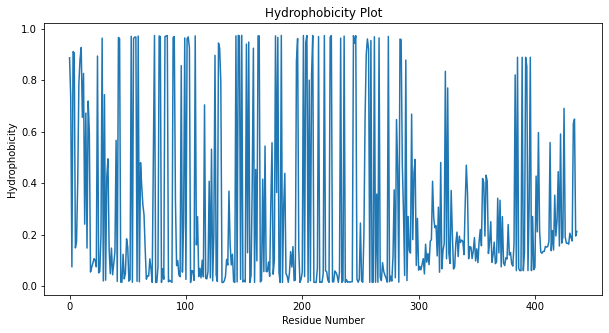

In [15]:
plt.figure(figsize=(10,5)) 
plt.plot(residue_pos,hydro_ratio)
plt.title("Hydrophobicity Plot")
plt.xlabel("Residue Number")
plt.ylabel('Hydrophobicity')

In [201]:
# credit: https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
def running_mean(x, N): # this definition is used to create values of a moving average it takes in data, and window size as input
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

Using moving window averaging method, smooth out the hydrophobicity values. You will need to select the window size yourself. Small window sizes (around 3-5 residues) would average local regions, whereas large window size(around 100-500 residues will highlight larger domain properties). Plot the smoothed entropy values over the entire length of the multiple alignment. To smooth a vector, you can use movmean() in Matlab. In python, you can use convolve() or other approaches listed in: https://stackoverflow.com/questions/13728392/moving-average-or-running-mean Make sure to cite any code-block you borrow from other resources.

In [202]:
window = 20
mva_hydro = running_mean(hydro_ratio,window)

Text(0, 0.5, 'Hydrophobicity')

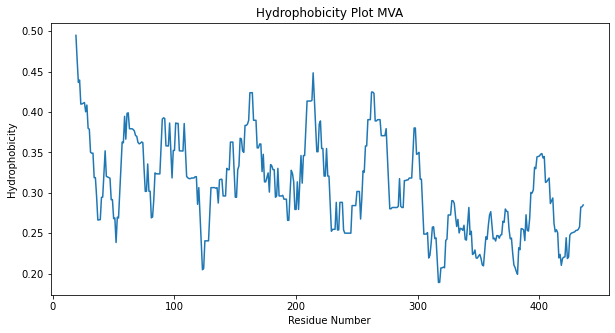

In [203]:

plt.figure(figsize=(10,5)) 
plt.plot(residue_pos[window-1:],mva_hydro)
plt.title("Hydrophobicity Plot MVA")
plt.xlabel("Residue Number")
plt.ylabel('Hydrophobicity')

Which part of the multiple alignment is composed of more hydrophilic amino acids? Use visual inspection of the smoothed hydrophobicity plot. You may need to adjust the smoothing window size above to support your claim. Use code in combination with comments/fprintf to answer this question.

In [204]:
# fprintf('Most hydrophilic region is around alignment position [%d].\n',pos);

### Calculate Entropy
Calculate entropy of each alignment column from the PSSM. No need to worry about log2(0) being nan, because we have added pseudo-counts, which makes sure there is no zero in the PSSM matrix.<br><br>
No need to worry about nan, because we have added pseudo-counts.<br><br>
Using moving window averaging method, smooth out the entropy values. You need to select the window size yourself. Plot the smoothed entropy values over the entire length of the multiple alignment.

In [205]:
entropy_val = [] #This section calculates the entropy for every column in the multiple alignment 
for i in range(len(pssm.columns)):
    aa_freq = pssm[:][i]
    entropy = [-(x*math.log(x,2)) for x in aa_freq]
    entropy_val.append(entropy)
entropy_y = [sum(ent_col) for ent_col in entropy_val ]


In [206]:
window = 20
mva_hydro = running_mean(entropy_y,window)

Text(0, 0.5, 'Entropy')

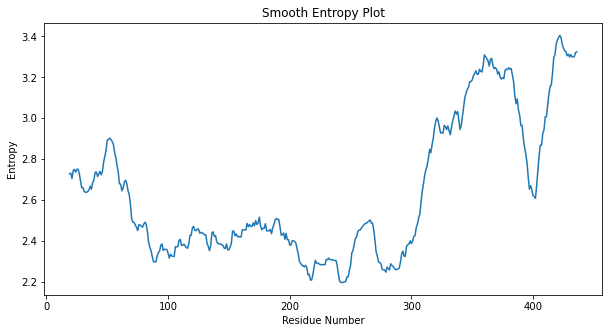

In [207]:
plt.figure(figsize=(10,5)) 
plt.plot(residue_pos[window-1:],mva_hydro)
plt.title("Smooth Entropy Plot")
plt.xlabel("Residue Number")
plt.ylabel('Entropy')

Identify the "region" of the the multiple alignment that is most conserved. Assume a "region" is defined by the same window definition used to smooth the entropy values above. Use the smoothed entropy values to answer this question. You may need to adjust the smoothing window size to support your interpretation. Use code in combination with comments to answer this question.

In [208]:
# fprintf('Most conserved region is aroun position %d of the alignment.\n',pos);

### Sequence Logo
Display a sequence logo of the multiple alignment, centered around the most conserved region you identified above. The size of your sequence logo should be around 10-20 residues. Create a readable figure that highlihts the conserved residues.

In [209]:
aa_info = {} #this dictionary will house all of the amino acid frequency data
for letter in look_up:
    aa_info[letter]=[]

In [210]:
for i in range(len(entropy_y)):
    col_factor = math.log(20,2) - entropy_y[i]
    info = [x*col_factor for x in pssm[i]]
    for k in range(len(info)):
        aa_info[aa_list[k]].append(info[k])

In [211]:
seq_profile = pd.DataFrame.from_dict(aa_info)

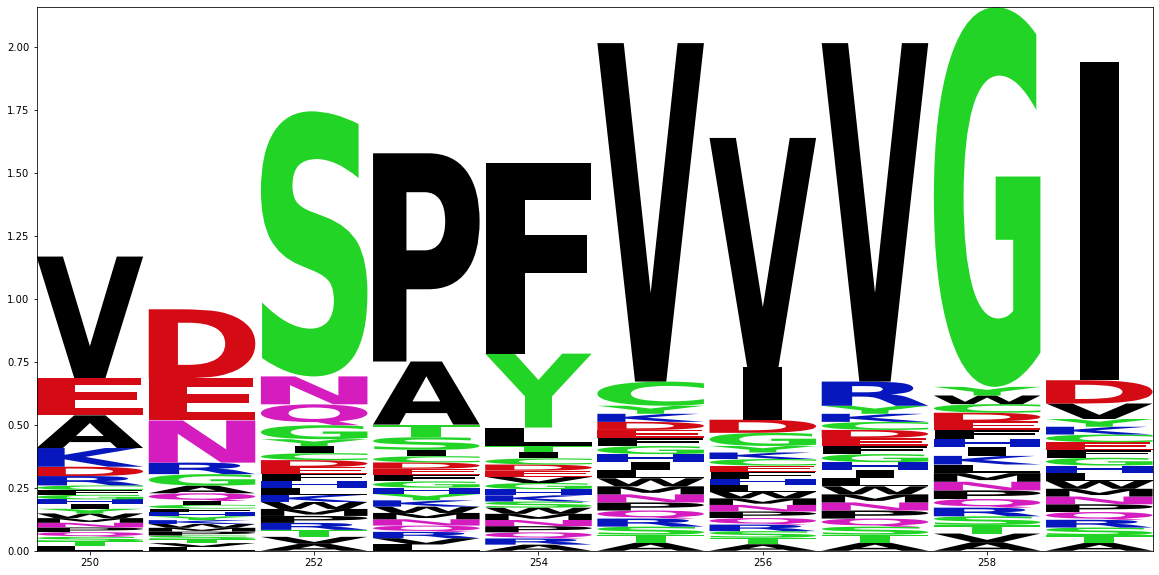

In [212]:
logo = lm.Logo(seq_profile.iloc[250:260], figsize=(20, 10))